In [1]:
%load_ext autoreload
%autoreload 2
import os
import random

import hydra
import numpy as np
import torch
from dataloader import ElectricDevices
from hydra.experimental import compose
from hydra.experimental import initialize_config_dir
from interpretability import get_hist
from interpretability import global_interpretability
from interpretability import input_max_neuron
from interpretability import neuron_max_class
from interpretability import shapley_bottleneck_vs_class
from interpretability import shapley_bottleneck_vs_output
from interpretability import shapley_input_vs_bottleneck
from interpretability import shapley_input_vs_class
from interpretability import shapley_input_vs_output
from models.CAE import CAE
from utils import accuracy
from utils import data_bottleneck_exploration
from utils import data_input_exploration
from utils import get_predictions
from utils import observation_reconstruction
from utils import reconstruction

torch.manual_seed(4444)
np.random.seed(4444)
random.seed(4444)

# Model

In [2]:
with initialize_config_dir(config_dir=os.path.abspath("../src/configs")):
    cfg = compose(config_name="config")

dl = ElectricDevices()
data_train, data_valid, data_test = dl()

X_train, y_train = data_train[:, :, :-1], data_train[:, :, -1]
X_valid, y_valid = data_valid[:, :, :-1], data_valid[:, :, -1]
X_test, y_test = data_test[:, :, :-1], data_test[:, :, -1]

In [3]:
model = CAE(cfg.model, num_classes=cfg.model.num_classes)
# torch.save(model.state_dict(), "../weights/mod.pth")
model.load_state_dict(torch.load("../weights/mod.pth"))

<All keys matched successfully>

Predict testing data

In [4]:
 X_testp, y_testp = get_predictions(model, X_test)

# Evaluate

## Reconstruction

In [5]:
reconstruction(X_test, X_testp)

Distance Correlation avg and std: 0.731706300394008 0.26447387261251154
NRMSE: 0.19742132723331451



## Reconstruction of individual observations

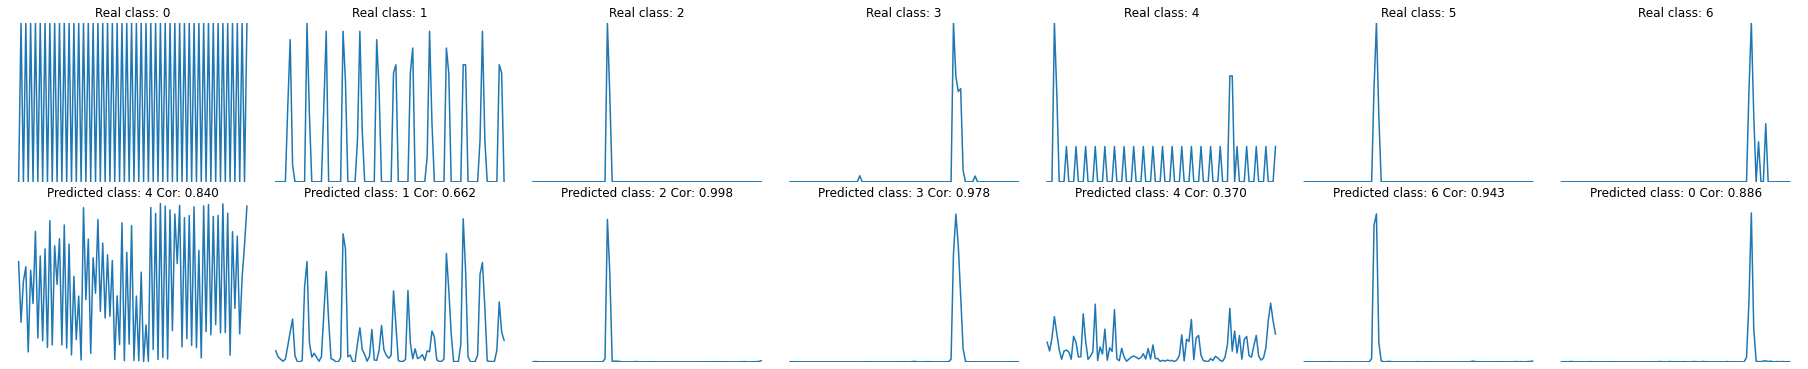

In [6]:
# SELECTED = [3279, 1156, 7419, 5046, 3323, 6485, 5497]

SELECTED = [
    np.random.choice([i for i, x in enumerate(y_test) if int(x) == j])
    for j in range(cfg.model.num_classes)
]

observation_reconstruction(SELECTED, X_test, X_testp, y_test, y_testp)

## Accuracy

Accuracy: 0.6188561794838542


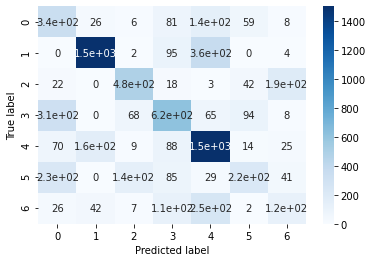

In [7]:
accuracy(y_test, y_testp)

# Data Exploration

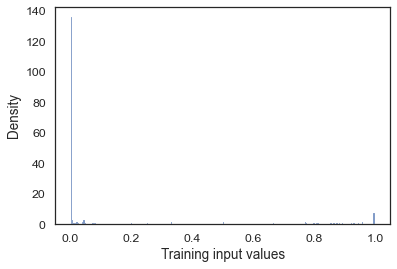

In [9]:
data_input_exploration(X_train)

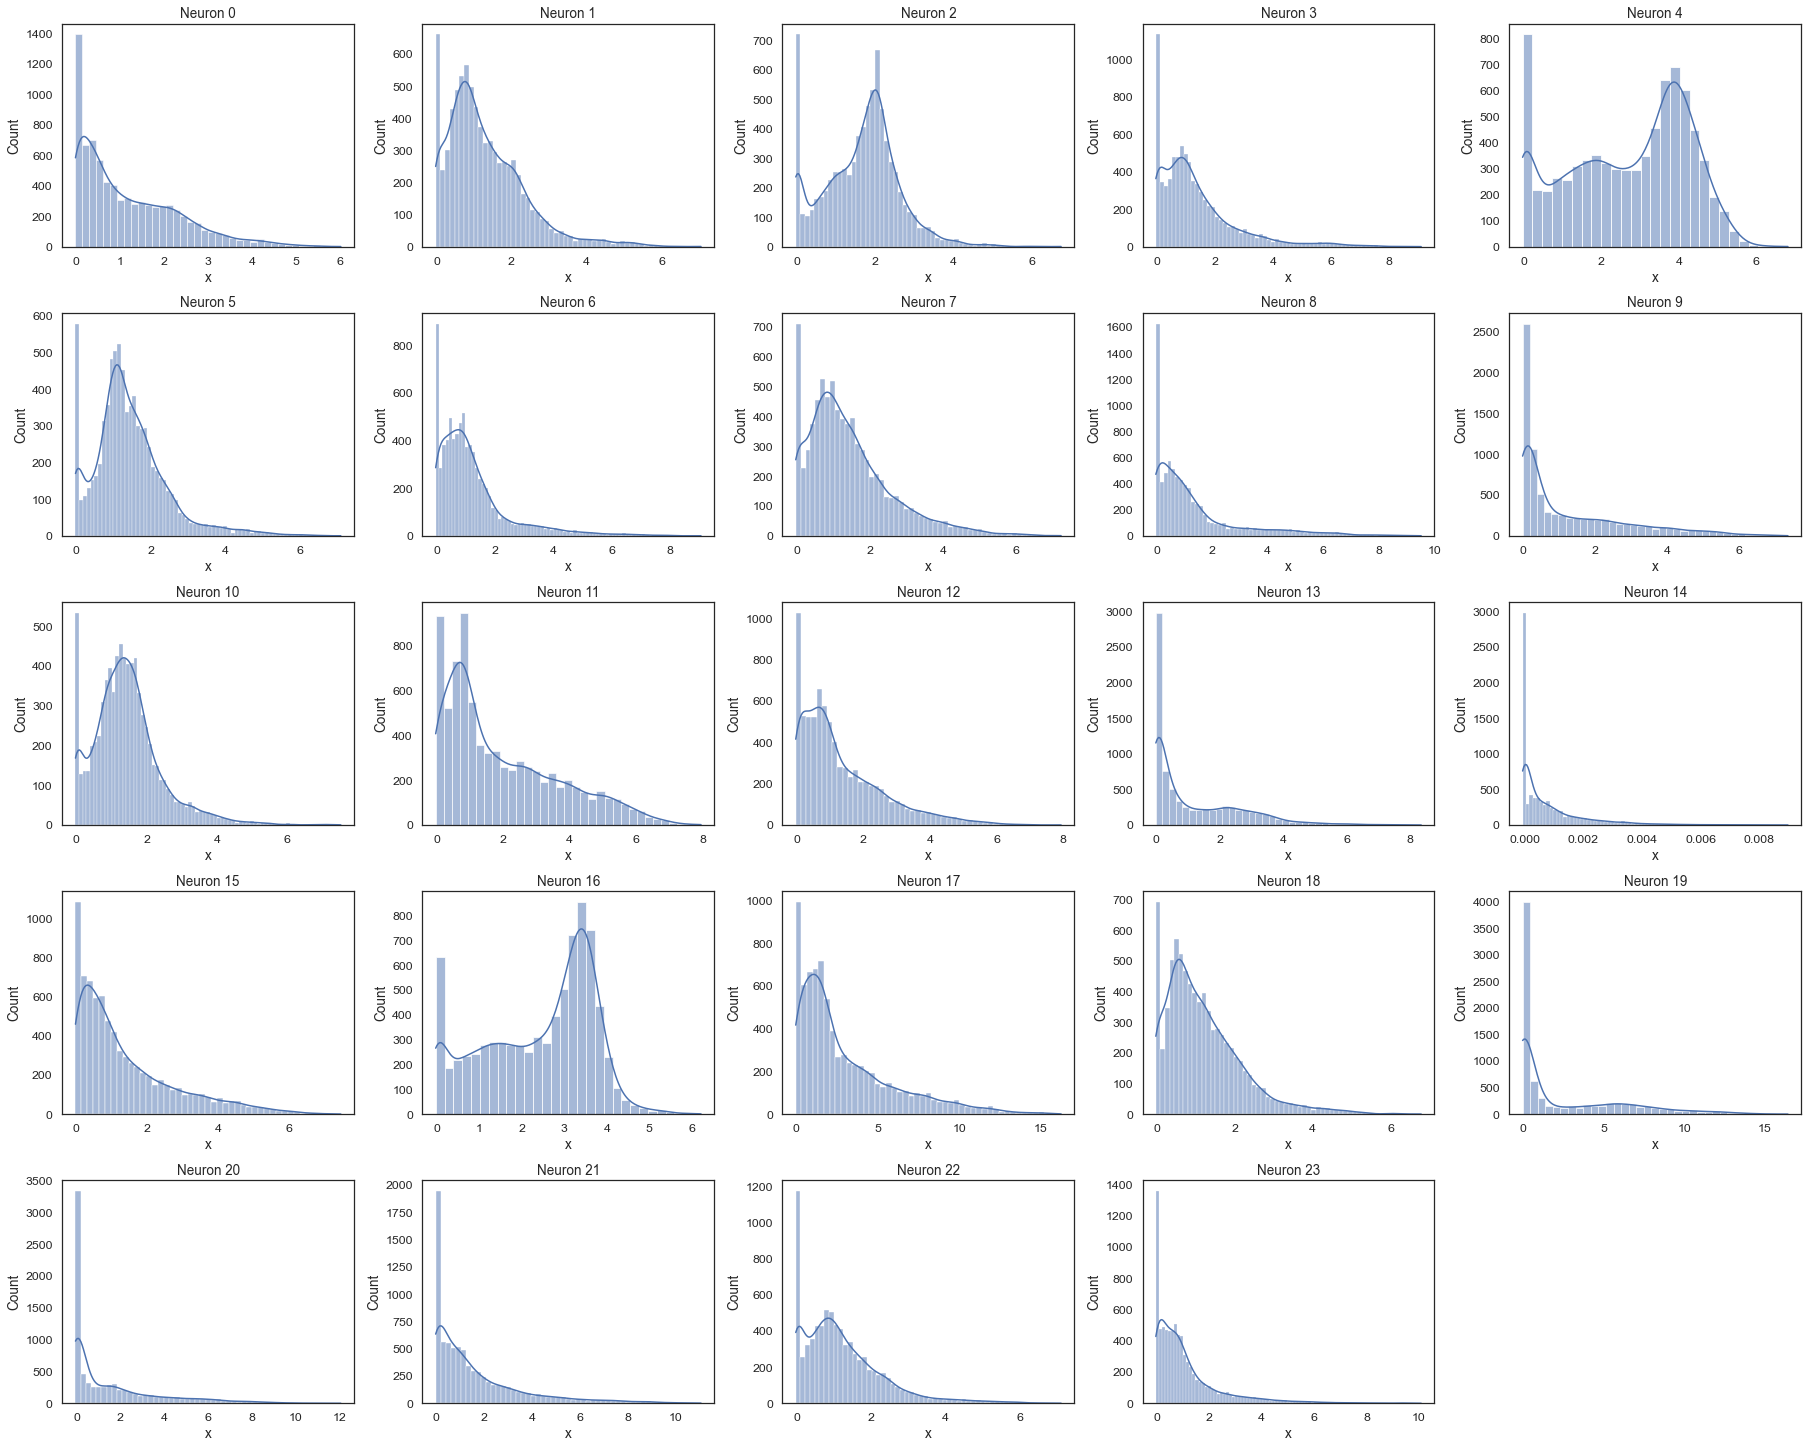

In [10]:
data_bottleneck_exploration(model, X_train)

# Interpretability

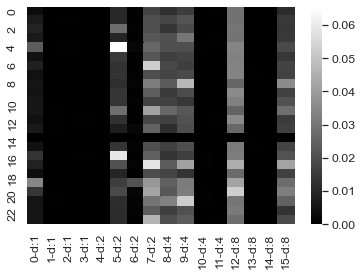

In [11]:
global_interpretability(model)

In [16]:
hist_input = [get_hist(X_train[:, 0, i]) for i in range(cfg.model.length)]
aux = model.encoder(X_train, False).detach().numpy()
hist_bn = [get_hist(aux[:, i]) for i in range(cfg.model.bottleneck_nn)]

In [ ]:
shapley_input_vs_output(model, SELECTED, X_test, hist_input)

In [ ]:
shapley_bottleneck_vs_output(model, SELECTED, X_test, hist_bn)

In [ ]:
shapley_input_vs_bottleneck(model, SELECTED, X_test, hist_input)

In [ ]:
shapley_bottleneck_vs_class(model, SELECTED, X_test, hist_bn)

In [ ]:
shapley_input_vs_class(model, SELECTED, X_test, hist_input)

# Feature Visualization

In [ ]:
input_max_neuron(model)

In [ ]:
neuron_max_class(model)